In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

True
True


In [4]:
project_name = 'dogbreeds'
PATH = "data/breeds/"
arch = resnext101

In [5]:
n = len(list(open(f'{PATH}labels.csv'))) - 1
val_idxs = get_cv_idxs(n)

def get_data(bs = 64, sz = 224, val = True):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on,
                           max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', num_workers=8,
               val_idxs=val_idxs if val else None, suffix='.jpg', tfms=tfms, bs=bs)
#     data = ImageClassifierData.from_paths(PATH, tfms=tfms)
    
    return data if sz>300 else data.resize(340, 'tmp')

In [11]:
learn = ConvLearner.pretrained(arch, 
                               data = get_data(bs = 32, sz = 224), 
                               precompute = True, 
                               ps = [0.5, 0.5, 0.5])
# xtra_fc=[500]

 74%|███████▍  | 190/256 [00:02<00:00, 75.52it/s, loss=2.49]


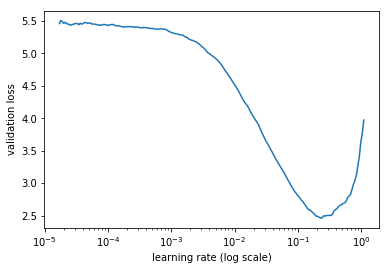

In [12]:
lr_find = learn.lr_find()
learn.sched.plot()

In [14]:
lr = 1e-2

In [15]:
learn.fit(lr, 3)
learn.save(f"{project_name}_initial_fit")

epoch      trn_loss   val_loss   accuracy                     
    0      0.742781   0.349929   0.902642  
    1      0.439417   0.278747   0.913405                     
    2      0.328117   0.261976   0.919276                     



In [16]:
learn.precompute = False

In [17]:
learn.fit(lr, 3)
learn.save(f"{project_name}_precompute")

epoch      trn_loss   val_loss   accuracy                    
    0      0.370807   0.259017   0.913405  
    1      0.32808    0.249157   0.915362                    
    2      0.32082    0.246472   0.915851                    



In [18]:
# learn.load(f"{project_name}_precompute")

 77%|███████▋  | 198/256 [00:26<00:07,  7.43it/s, loss=0.923]

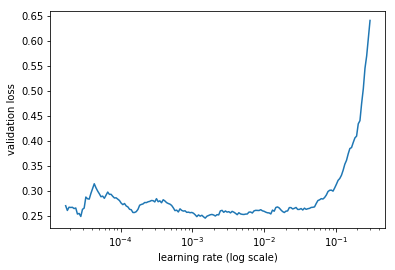

In [19]:
lr_find = learn.lr_find()
learn.sched.plot()

In [20]:
lr = 1e-4
lrs = [lr/6, lr/3, lr]
learn.unfreeze()
learn.bn_freeze(True) 

In [21]:
learn.set_data(get_data(bs = 32 ,sz = 270, val = False))

In [31]:
learn.fit(lrs, n_cycle = 3, cycle_len = 1, cycle_mult = 2)
learn.save(f"{project_name}_unfreeze")

epoch      trn_loss   val_loss   accuracy                    
    0      0.283387   0.252462   0.92955   
    1      0.270648   0.250009   0.929061                    
    2      0.286635   0.249584   0.929061                    
    3      0.277398   0.247032   0.928082                    
    4      0.272655   0.245674   0.928082                    
    5      0.262066   0.245045   0.928082                    
    6      0.258491   0.244957   0.928082                    


In [32]:
log_preds,y = learn.TTA(is_test = True)
probs = np.exp(log_preds)

In [37]:
probs = np.mean(probs, axis = 0)

In [38]:
ds = pd.DataFrame(probs)
ds.columns = learn.data.classes
ds.insert(0, 'id', [o[5:-4] for o in learn.data.test_ds.fnames])

In [39]:
SUBM = f'{PATH}sub/' 
os.makedirs(SUBM, exist_ok=True) 
ds.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)


In [40]:
! kaggle competitions submit -c dog-breed-identification -f {SUBM}subm.gz -m "fastai awsp3 resnet101"

Successfully submitted to Dog Breed Identification